In [1]:
import NewCore
import os
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane')

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

%matplotlib inline



from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import binary_fill_holes as bfh

from ipywidgets import interact, fixed
from IPython.display import display

def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

import skimage
from skimage import filters

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()

def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

# Dicom files

Reading file: /Volumes/FAIR/Sinead/DC-Project-Images/original/Sample6/
CT image


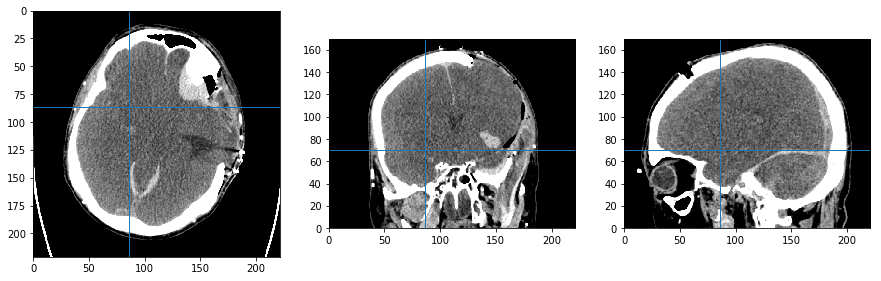

Brain mask


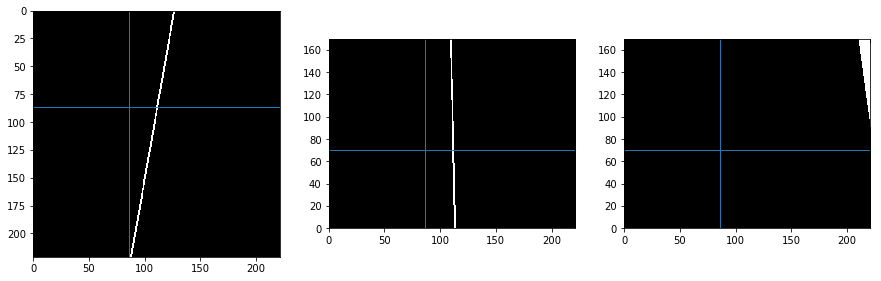

In [2]:
paths =['/MachineLearning/python tutorials/tutorial3/',
        '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample3/',
        '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample6/',
         '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample4/',
         '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample5/S5_Pre_rigid.nrrd',
         '/Users/fair00542/Desktop/TestImages/ScanB/ScanB',
         '/Users/fair00542/Desktop/TestImages/ScanF/ScanF']

# print( "Reading Dicom directory:", paths[6])
# path = paths[6]
# reader = sitk.ImageSeriesReader()
# dicom_names = reader.GetGDCMSeriesFileNames(path)
# reader.SetFileNames(dicom_names)
# img = reader.Execute()
# img = sitk.ReadImage(dicom_names)
# msk = sitk.ReadImage(path + '/opt_foramen_cut.nii.gz')

path = paths[2]
print("Reading file:", path)
img = sitk.ReadImage(path + '/Post/SB_Post-op.nrrd')
msk = sitk.ReadImage(path + '/Post/Final_midplane_post.nii.gz')

print('CT image')
display_image(img, x=200, y=200, z=100, window=120, level=40)

print('Brain mask')
display_image(msk, x=200, y=200, z=100)

In [3]:
# # Pre-op midplane parameters
# paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Final_preop.npy')
# file,a,b,c,d =paras[15]

# a,b,c,d = a.astype(float),b.astype(float),c.astype(float),d.astype(float)
# file

# Post-op midplane parameters
paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Final_postop.npy')
file,a,b,c,d =paras[4]
a,b,c,d = a.astype(float),b.astype(float),c.astype(float),d.astype(float)
file

b'SampleB'

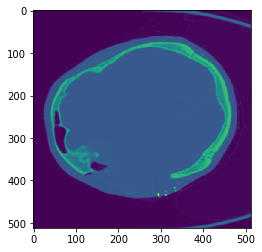

In [4]:
img_array = sitk.GetArrayFromImage(img)
msk_array = sitk.GetArrayFromImage(msk)

array = np.swapaxes(img_array,0,2)
plt.imshow(array[:,:,100])
plt.show()

In [5]:
ConstPixelSpacing = img.GetSpacing()
# Threshold to get the bone and the softtissue
bone = NewCore.thresholdnp(array,1100,1500)
softtissue = NewCore.thresholdnp(array,0,80)
# Reshape to make voxel spacing of 1 mm3
boneReshaped = NewCore.reshape(bone, ConstPixelSpacing)
softtissueReshaped = NewCore.reshape(softtissue,ConstPixelSpacing)
arrayReshaped = NewCore.reshape(array,ConstPixelSpacing)

In [6]:
# get coordinates of bones
X = np.where(boneReshaped>0)
X_array = np.where(arrayReshaped>0)
# this step exchanges the x y axis.
X = np.matrix(np.column_stack((X[0],X[1],X[2])))
X_array = np.matrix(np.column_stack((X_array[0],X_array[1],X_array[2])))
# Feature Normalization for X matrix
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane')
import Functions
# X_norm,mu,std = Functions.featureNormalize(X)
X_norm,mu = Functions.featureNormalize(X);
m = X.shape[0] #Number of samples
p = np.mean(X_array,0); #Points centroid
p = np.array(p)[0] #p becomes an array
p_original = p/ConstPixelSpacing

# midplane normal vector regulate the direction
if a<0:
    a,b,c,d = a*-1,b*-1,c*-1,d*-1
n = np.array((a,b,c))

#define rotation axis in plane, in z direction correlates to skew angle
from sympy import *
import sympy
x = sympy.symbols('x')
x1 = solve(a*x + b*100 + c*0 - d, x)
x2 = solve(a*x + b*100 + c*100 - d, x)
k = np.array((x1[0]-x2[0],0,-100)).astype(float)
# k = k/np.sqrt((k[0]**2 + k[1]**2 + k[2]**2))
vk_unit = Functions.unit_vector(k)
vk_unit

## Define rotation axis in y direction, correlating to the orientation angle
x = sympy.symbols('x')
x3 = solve(a*x + b*0.0 + c*100.0- d, x)
x4 = solve(a*x + b*100.0 + c*100.0 - d, x)

k2 = np.array((x3[0]-x4[0],-100.0,0.0)).astype(float)
vk2_unit = Functions.unit_vector(k2)
# the new_vk corresponds to the reshaped version of array, as displayed in ITK
# new_vk = Functions.unit_vector(vk_unit*ConstPixelSpacing)


In [7]:
p_original

array([ 247.38557957,  265.77718114,  110.81906241])

In [65]:
v = np.array([a,b,c])
# k2_unit adjust on coronal slice
# k_unit adjsut first XiangXian
v_rot = Functions.rotate_vector(v,vk2_unit,-5.0)
v_rot2 = Functions.rotate_vector(v_rot,vk_unit,1.5)
a_opt_2,b_opt_2,c_opt_2 = v_rot2
q  = np.zeros((3,1));
q[0],q[1],q[2] = a_opt_2,b_opt_2,c_opt_2;

d_opt_2 = np.dot(p_original,q)
d_opt_2 = d_opt_2-5.0

<IPython.core.display.Javascript object>


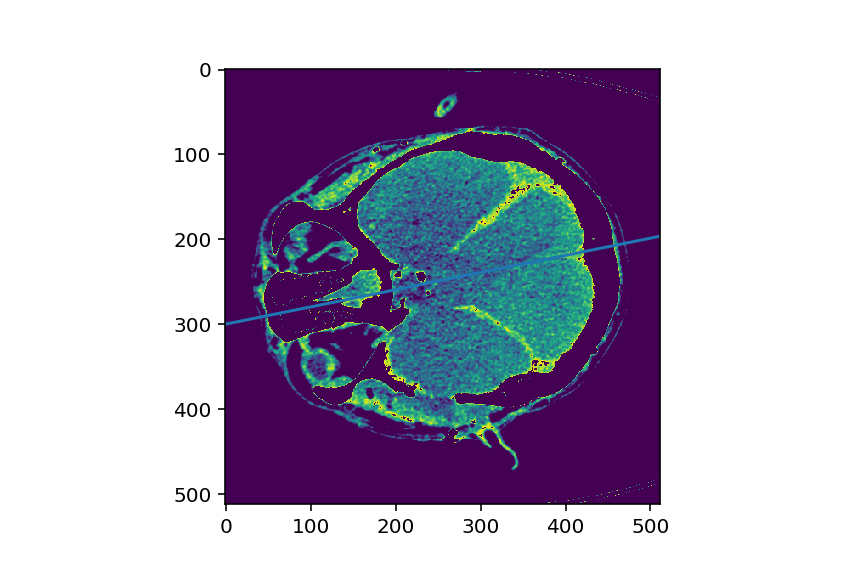

In [66]:
i = 82

% matplotlib nbagg
x = np.linspace(0,bone[:,:,1].shape[0], 2)
# y = np.array((d-c*i-a*x)/b)
z1 = np.array((d_opt_2-b_opt_2*i-a_opt_2*x)/c_opt_2)
y1 = np.array((d_opt_2-c_opt_2*i-a_opt_2*x)/b_opt_2)
# plt.plot(z1,x, )
plt.plot(y1,x,)
plt.imshow(softtissue[:,:,i])
plt.ion()

In [67]:
crossShape = bone[:,:,10].shape
mask = np.zeros(bone.shape)
for i in range(bone.shape[2]):
    mask1 = np.fromfunction(lambda x,y: x > ((d_opt_2-i*c_opt_2-y*b_opt_2)/a_opt_2-2), crossShape)
    mask2 = np.fromfunction(lambda x,y: x < ((d_opt_2-i*c_opt_2-y*b_opt_2)/a_opt_2+2), crossShape)
    maski = np.multiply(mask1, mask2)
    mask[:,:,i] = maski

# swap back the axes    
mask = np.swapaxes(mask,0,2)
    
img_mask = sitk.GetImageFromArray(mask)
img_mask.CopyInformation(img)
os.chdir(path)
sitk.WriteImage(img_mask,'new_MP.nii.gz')


<IPython.core.display.Javascript object>


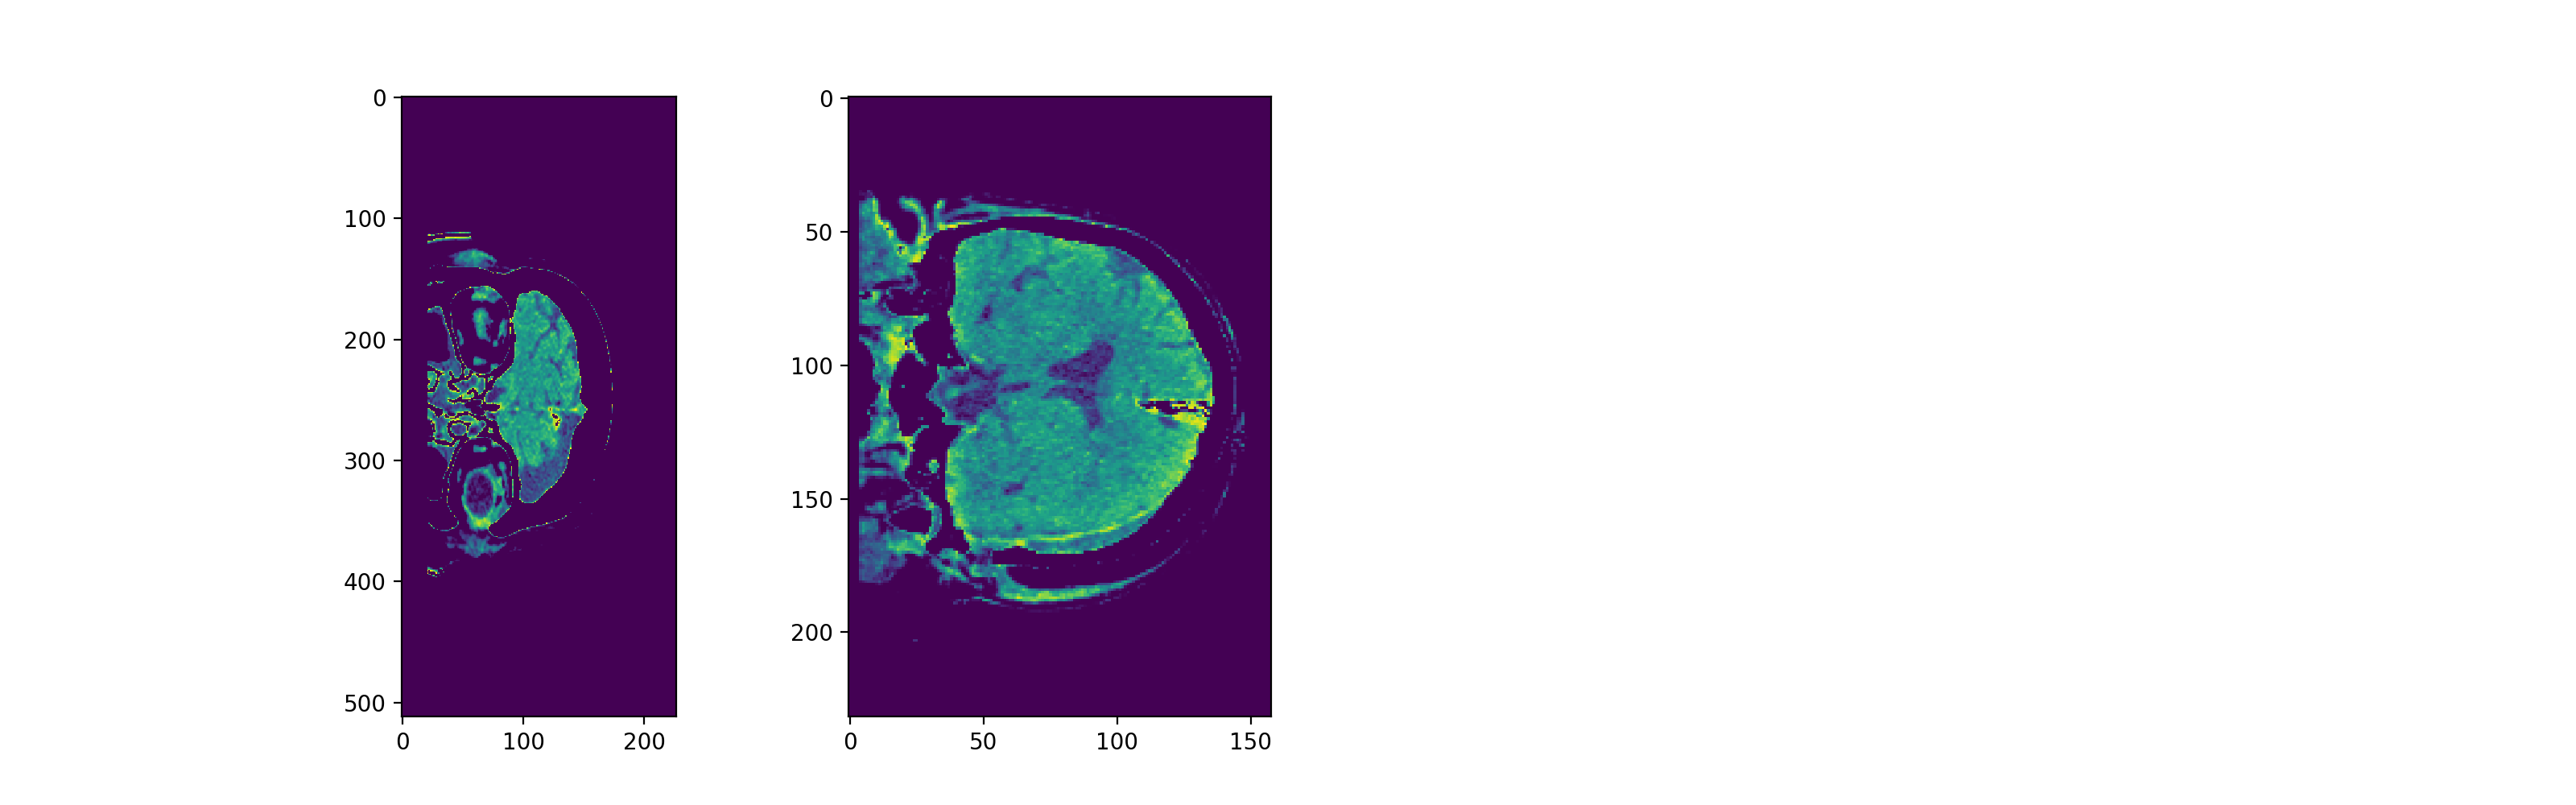

In [56]:
i = 100

plt.figure(figsize=(16,5))
plt.subplot(141)

plt.imshow(softtissue[:,i,:])
plt.subplot(142)
plt.imshow(softtissueReshaped[:,i,:])
plt.show()

## Rewrite the parameter list

In [68]:
dirname = os.path.split(os.path.dirname(path))[1]
paras[4] = np.array((dirname,a_opt_2,b_opt_2,c_opt_2,d_opt_2[0]))
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane')
np.save('Final_postop.npy', np.array(paras))

In [69]:
paras[4],v_rot2

(array([b'Sample6', b'0.972642733041', b'0.196807153953', b'0.123422275198',
        b'301.60217765'],
       dtype='|S17'), array([ 0.97264273,  0.19680715,  0.12342228]))

# Rewrite the Final midplane + deformed plane file

In [71]:
ML_old = sitk.ReadImage(path + '/Post/Final_midplane_post.nii.gz')
ML_array = sitk.GetArrayFromImage(ML_old)
# ML_array = np.swapaxes(ML_array,0,2)
# ideal midplane
Ideal_ML = np.multiply(ML_array == 1,ML_array)
# Deformed midplane
Deformed_ML = np.multiply(ML_array == 2,ML_array)

New_MP = np.zeros(ML_array.shape)
New_MP[ML_array == 2] = 2
New_MP[mask==1] = 1

New_MP_mask = sitk.GetImageFromArray(New_MP)
New_MP_mask.CopyInformation(img)
os.chdir(path)
sitk.WriteImage(New_MP_mask,'new_MP.nii.gz')